In [3]:
import os
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# torchsummary for easy checking and debugging
from torchsummary import summary

# others for notebook UI and latent space visualization
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

from model import AutoEncoder
from util import FontDataset, display_grid

# Checking is CUDA available on current machine
DEVICE = "cuda:2" if torch.cuda.is_available() else "cpu"
print("Project running on device: ", DEVICE)

Project running on device:  cuda:2


In [5]:
config = {
    "batch_size": 64,
    "epochs": 30,
}

dataset = FontDataset("fonts.hdf5")
data_loader = DataLoader(dataset, batch_size=config['batch_size'])

In [6]:
it = iter(data_loader)

In [7]:
batch = next(it)

In [8]:
labels

NameError: name 'labels' is not defined

In [32]:
labels.repeat_interleave(62).shape

torch.Size([3968])

In [22]:
k = fonts.reshape(-1, 64, 64)

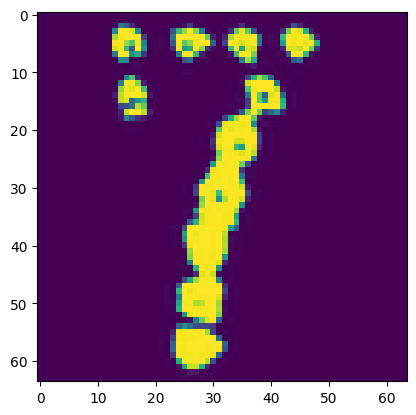

In [26]:
plt.imshow(k[121])

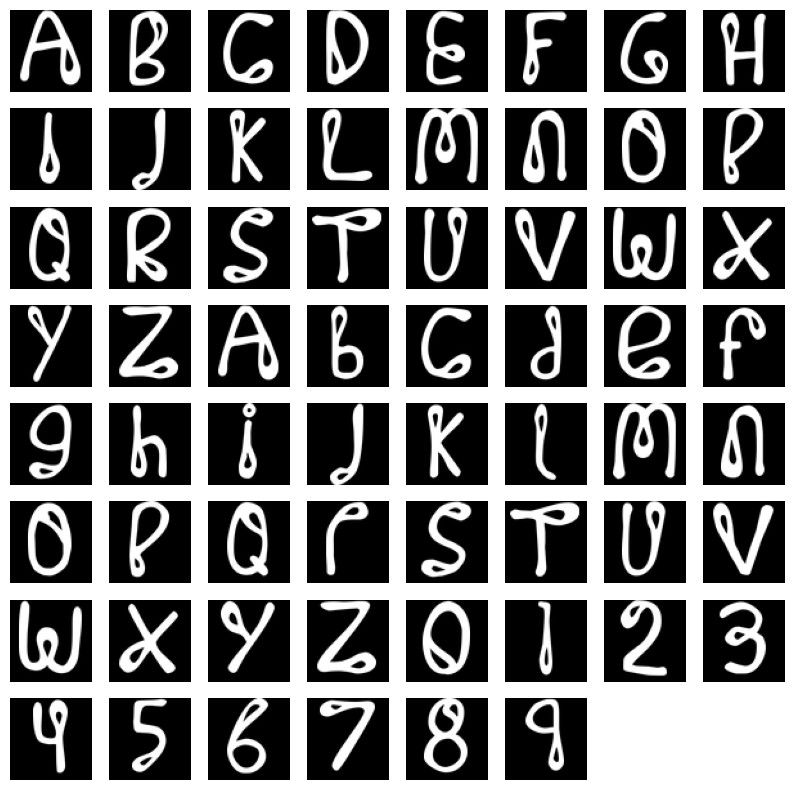

In [15]:
batch = next(it)

labels = batch[0]
fonts = batch[1]

font = fonts[0]

# # rearrange the tensor to a grid of 8x8 images, each of size 64x64
# first_font_grid = first_font.view(8, 8, 64, 64)

fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for i in range(62):
    axs[i // 8, i % 8].imshow(font[i], cmap='gray')
    axs[i // 8, i % 8].axis('off')  # hide the axes
    
axs[7, 6].axis('off')
axs[7, 7].axis('off')

plt.show()

In [75]:
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=8192, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=32, out_features=8192, bias=True)
    (conv): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), ou

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [77]:
checkpoint = torch.load("checkpoints/chkpt_epoch_9.pth", map_location="cpu")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(DEVICE)

AutoEncoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=8192, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=32, out_features=8192, bias=True)
    (conv): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), ou

In [78]:
batch = next(it)

labels = batch[0].repeat_interleave(62).to(DEVICE)
fonts = batch[1].reshape(-1, 1, 64, 64).to(DEVICE)

sample = fonts[0].reshape(1, 1, 64, 64)

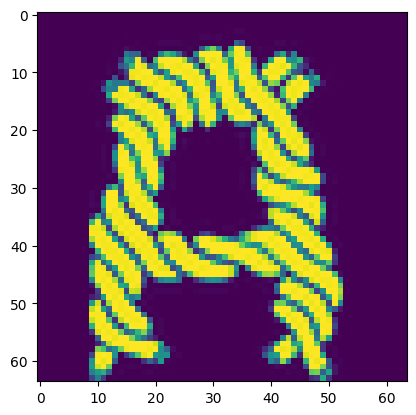

In [79]:
plt.imshow(sample.view(64,64).cpu())

In [84]:
encoded_image = model.encoder(sample)

In [85]:
encoded_image

tensor([[-0.7528, -1.0258,  1.9760, -3.2832,  0.8598,  1.4681,  1.5690, -8.5535,
          0.3154, -2.5130, -4.5309, -0.6901, -4.3675,  0.8095, -0.3501, -0.3906,
          1.5088,  2.0178, -4.8594, -1.6619,  0.7580,  3.9739,  4.8695,  1.6772,
         -0.3899,  1.2305, -1.5696, -1.7726,  2.1270, -3.3503, -2.2199,  1.4711]],
       device='cuda:2', grad_fn=<AddmmBackward0>)

In [86]:
model.decoder(encoded_image)

RuntimeError: Given transposed=1, weight of size [128, 128, 3, 3], expected input[1, 1, 1, 8192] to have 128 channels, but got 1 channels instead

In [87]:
model(sample)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1133072/2453837396.py", line 1, in <module>
    model(sample)
  File "/home/jupyter-maxh/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/jupyter-maxh/fonts/model.py", line 140, in forward
    return self.decoder(self.encoder(x))
  File "/home/jupyter-maxh/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/jupyter-maxh/fonts/model.py", line 124, in forward
    x = self.conv(x)
  File "/home/jupyter-maxh/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/jupyter-maxh/.local/lib/python3.9/site-p

In [37]:
output_image = model.decoder(encoded_image[0])

RuntimeError: Given transposed=1, weight of size [128, 128, 3, 3], expected input[1, 1, 1, 8192] to have 128 channels, but got 1 channels instead

In [ ]:

# Print the latent representation for the first image in the batch
print(encoded_image[0])
print(encoded_image.shape)

encoded_image = encoded_image[0].repeat(64).reshape(64, 32)

output_image = model.decoder(encoded_image)

#output_image = model(input_image)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
display_grid(input_image.cpu().squeeze(0)) # Remove the batch dimension for displaying
plt.title('Original Image')

plt.subplot(1, 2, 2)
display_grid(output_image.cpu().squeeze(0)) # Remove the batch dimension for displaying
plt.title('Reconstructed Image')

plt.show()